In [12]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
from pydantic import BaseModel, Field
import operator


In [13]:
generator_llm = ChatOpenAI(model = 'gpt-4o')
evaluator_llm = ChatOpenAI(model = 'gpt-4o-mini')
optimizer_llm = ChatOpenAI(model = 'gpt-40')

In [14]:
class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [15]:
# state 
class Tweetstate(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int 
    max_iteration: int
    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [16]:
def generate_tweet(state: Tweetstate):
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    tweet = generator_llm.invoke(messages)
    return {"tweet": tweet}

In [17]:
def evaluate_tweet(state:Tweetstate):
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
    Evaluate the following tweet:

    Tweet: "{state['tweet']}"

    Use the criteria below to evaluate the tweet:

    1. Originality – Is this fresh, or have you seen it a hundred times before?  
    2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
    3. Punchiness – Is it short, sharp, and scroll-stopping?  
    4. Virality Potential – Would people retweet or share it?  
    5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

    Auto-reject if:
    - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
    - It exceeds 280 characters
    - It reads like a traditional setup-punchline joke
    - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

    ### Respond ONLY in structured format:
    - evaluation: "approved" or "needs_improvement"  
    - feedback: One paragraph explaining the strengths and weaknesses 
    """)
]

    response = structured_evaluator_llm.invoke(messages)
    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}



In [18]:
def optimize_tweet(state: Tweetstate):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [20]:
def route_evaluation(state: Tweetstate):
    if state['evaluation'] == 'approved' or state["iteration"] >= state["max_iteration"]:
        return "approved"
    else:
        return "needs_improvement"

In [27]:
graph = StateGraph(Tweetstate)

graph.add_node("generate", generate_tweet)
graph.add_node("evaluate_tweet", evaluate_tweet)
graph.add_node("optimize_tweet", optimize_tweet)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate_tweet')
graph.add_conditional_edges('evaluate_tweet', route_evaluation, {'approved': END, 'needs_improvement': 'optimize_tweet'})
graph.add_edge('optimize_tweet', 'evaluate_tweet')

workflow = graph.compile()

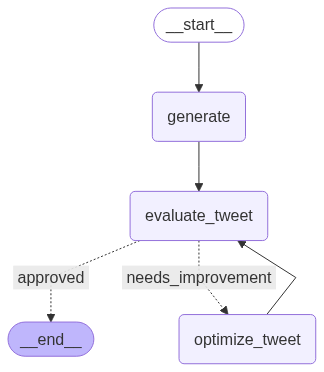

In [28]:
workflow

In [29]:
initial_state = {
    "topic": "America",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

In [30]:
result

{'topic': 'America',
 'tweet': AIMessage(content='America: the only place where you can buy a 100-pack of toilet paper, but your healthcare plan is strictly "fingers crossed." 🇺🇸', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 90, 'total_tokens': 122, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-C6CiTG8deGt27RUidkbjCPkrZ986p', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--da7a182e-fec8-4006-a825-24477b318575-0', usage_metadata={'input_tokens': 90, 'output_tokens': 32, 'total_tokens': 122, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 'evaluation': 'approved',
 'feedback': "Th